# Ultrasound Microrobot Preprocessing and Dataset

This notebook demonstrates a modular approach to:

1. **Preprocess the Ultrasound Data**: Convert ultrasound images (1920×1080) and corresponding bounding-box label files into a single `.amat` file per microrobot type.
2. **Create a PyTorch Dataset**: Define a dataset class (`USMicroMagDataset`) that loads the `.amat` file, reshapes the image data, and makes it available to your model.

The folder structure is assumed to be as follows:

```
UsMicroMagSet-main/
├── sample.yaml
├── images/
│   ├── train/   (contains many .png images)
│   ├── val/     (contains many .png images)
│   └── test/    (contains many .png images)
└── labels/
    ├── train/   (each image has a corresponding .txt file with bounding box info)
    ├── val/
    └── test/
```

The `sample.yaml` might look like:

```yaml
path: ../dataset/cylinder
train:
  - images/train
val:
  - images/val
test:
  - images/test
nc: 1 
names: ["cylinder"]
```

# E(n)-Equivariant Steerable CNNs  -  A concrete example


In [1]:
import sys
sys.path.append('../')

import os
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0" # no limit on MPS memory usage

import torch

from escnn import gspaces
from escnn import nn

# For preprocessing data
import os
import yaml
import numpy as np
from PIL import Image

# for Part 3
from torch.utils.data import Dataset
from torchvision.transforms import RandomRotation
from torchvision.transforms import Pad
from torchvision.transforms import Resize
from torchvision.transforms import ToTensor
from torchvision.transforms import Compose
from torchvision.transforms import InterpolationMode

## Part 1. Preprocess Ultrasound Data

This function reads ultrasound images and corresponding label files, then writes a space-delimited `.amat` file. Each row in the `.amat` file contains the flattened pixel values (from a 1920×1080 grayscale image) followed by the label values (for example, 5 numbers representing a bounding box).

In [41]:
# def preprocess_ultrasound_data(microrobot_folder, max_images=None):
#     """
#     Preprocess ultrasound images and labels for a given microrobot type.

#     Args:
#         microrobot_folder (str): Path to the folder containing sample.yaml, images/, and labels/
#         max_images (int or None): Maximum number of images to include per split (train/test).
#                                   If None, includes all available images.
    
#     Expects the following folder structure inside `microrobot_folder`:
    
#         sample.yaml
#         images/
#             train/   -- training images (.png)
#             test/    -- testing images (.png)
#             val/     -- validation images (.png)
#         labels/
#             train/   -- training label files (.txt)
#             test/    -- testing label files (.txt)
#             val/     -- validation label files (.txt)
    
#     The sample.yaml file is assumed to contain, for example:
    
#         path: ../dataset/cylinder
#         train:
#           - images/train
#         val:
#           - images/val
#         test:
#           - images/test
#         nc: 1 
#         names: ["cylinder"]
    
#     For training, we combine images from both "train" and "val" splits.
#     Each output .amat file will have one row per image:
#        [ flattened_pixels (1920x1080)  label_values ]
#     """
#     # Path to the sample.yaml file
#     print("Current working directory:", os.getcwd())

#     sample_yaml_path = os.path.join(microrobot_folder, "sample.yaml")
#     with open(sample_yaml_path, "r") as f:
#         config = yaml.safe_load(f)
    
#     # Define splits: combine "train" and "val" for training; test remains separate
#     splits = {"train": [], "test": []}
    
#     # Combine train and validation splits
#     for key in ["train", "val"]:
#         if key in config and config[key]:
#             for rel_dir in config[key]:
#                 splits["train"].append(os.path.join(microrobot_folder, rel_dir))
    
#     # Test split
#     if "test" in config and config["test"]:
#         for rel_dir in config["test"]:
#             splits["test"].append(os.path.join(microrobot_folder, rel_dir))

#     # Process each split
#     for mode, img_dirs in splits.items():
#         data_rows = []
#         count = 0  # Track how many images have been added
#         for img_dir in img_dirs:
#             # Determine corresponding labels directory by replacing "images" with "labels"
#             label_dir = img_dir.replace("images", "labels")
#             # List all PNG files in this directory
#             image_files = sorted([f for f in os.listdir(img_dir) if f.lower().endswith(".png")])
#             for img_file in image_files:
#                 if max_images is not None and count >= max_images:
#                     break  # Stop if limit reached
#                 # Full path to the image
#                 img_path = os.path.join(img_dir, img_file)
#                 # Open image, convert to grayscale ('F')
#                 image = Image.open(img_path).convert('F')
#                 # Convert to numpy array and flatten (original size: 1920x1080)
#                 img_array = np.array(image, dtype=np.float32).flatten()
                
#                 # Find the corresponding label file
#                 label_filename = os.path.splitext(img_file)[0] + ".txt"
#                 label_path = os.path.join(label_dir, label_filename)
#                 with open(label_path, "r") as lf:
#                     # For example: "0 0.569076 0.381246 0.115152 0.130603"
#                     label_line = lf.readline().strip()
#                     label_values = [float(x) for x in label_line.split()[1:]]
                
#                 # Concatenate flattened image and label values
#                 row = np.concatenate([img_array, np.array(label_values, dtype=np.float32)])
#                 data_rows.append(row)
#                 count += 1
            
#             if max_images is not None and count >= max_images:
#                 break  # Don't process more folders if limit is reached
        
#         # If any data is found, stack and save as .amat
#         if data_rows:
#             data_matrix = np.vstack(data_rows)
#             microrobot_type = config["names"][0]  # e.g., "cylinder"
#             suffix = f"_{max_images}" if max_images is not None else ""
#             amat_filename = f"USMicroMagSet_processed/ultrasound_{microrobot_type}_{mode}{suffix}.amat"
#             np.savetxt(amat_filename, data_matrix, fmt="%.6f")
#             print(f"Saved {amat_filename} with shape {data_matrix.shape}")
#         else:
#             print(f"No images found for split {mode} in {microrobot_folder}.")

# # Example usage (uncomment and set your folder path):
# max_images = 128
# preprocess_ultrasound_data("UsMicroMagSet-main/flagella", max_images=max_images)

## Part 2. The model

Finally, we build a **Steerable CNN** and try it on USMicroMagSet.

Let's also use a group a bit larger: we now build a model equivariant to $8$ rotations.
We indicate the group of $N$ discrete rotations as $C_N$, i.e. the **cyclic group** of order $N$.
In this case, we will use $C_8$.

Because the inputs are still gray-scale images, the input type of the model is again a *scalar field*.

However, internally we use *regular fields*: this is equivalent to a *group-equivariant convolutional neural network*.

Finally, we build *invariant* features for the final classification task by pooling over the group using *Group Pooling*.

The final classification is performed by a two fully connected layers.

**Here is the definition of our model:**

In [2]:
class C8SteerableCNN(torch.nn.Module):
    
    def __init__(self, labels_points=4, input_size=256):
        
        super(C8SteerableCNN, self).__init__()
        
        # the model is equivariant under rotations by 45 degrees, modelled by C8
        self.r2_act = gspaces.rot2dOnR2(N=8)
        
        # the input image is a scalar field, corresponding to the trivial representation
        in_type = nn.FieldType(self.r2_act, [self.r2_act.trivial_repr])
        
        # we store the input type for wrapping the images into a geometric tensor during the forward pass
        self.input_type = in_type
        
        # convolution 1
        # first specify the output type of the convolutional layer
        # we choose 24 feature fields, each transforming under the regular representation of C8
        out_type = nn.FieldType(self.r2_act, 24*[self.r2_act.regular_repr])
        self.block1 = nn.SequentialModule(
            # When you rotate a square image, the corners will often rotate out of frame or expose blank areas — breaking the assumption of rotation symmetry. To restore symmetry, you can mask out a circular region, where every direction is treated equally.
            nn.MaskModule(in_type, input_size, margin=1),
            nn.R2Conv(in_type, out_type, kernel_size=7, padding=1, bias=False),
            nn.InnerBatchNorm(out_type), # equivariant version of Batch Normalization. It normalizes all channels together
            nn.ReLU(out_type, inplace=True)
        )
        
        # convolution 2
        # the old output type is the input type to the next layer
        in_type = self.block1.out_type
        # the output type of the second convolution layer are 48 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 24*[self.r2_act.regular_repr])
        self.block2 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )
        self.pool1 = nn.SequentialModule(
            nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=2)
        ) # pooling is invariant
        
        # convolution 3
        # the old output type is the input type to the next layer
        in_type = self.block2.out_type
        # the output type of the third convolution layer are 48 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 48*[self.r2_act.regular_repr])
        self.block3 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )
        
        # convolution 4
        # the old output type is the input type to the next layer
        in_type = self.block3.out_type
        # the output type of the fourth convolution layer are 96 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 48*[self.r2_act.regular_repr])
        self.block4 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )
        self.pool2 = nn.SequentialModule(
            nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=2)
        )
        
        # convolution 5
        # the old output type is the input type to the next layer
        in_type = self.block4.out_type
        # the output type of the fifth convolution layer are 96 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 48*[self.r2_act.regular_repr])
        self.block5 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )

        self.pool3 = nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=2, padding=0, )
        
        # convolution 6
        # the old output type is the input type to the next layer
        in_type = self.block5.out_type
        # the output type of the sixth convolution layer are 64 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 48*[self.r2_act.regular_repr])
        self.block6 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=1, bias=False, stride=1),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )
        # Pointwise over max pooling since max pooling wouldn't be equivariant in rotations
        self.pool4 = nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=1, padding=0, )

        # convolution 7
        # the old output type is the input type to the next layer
        in_type = self.block6.out_type
        # the output type of the sixth convolution layer are 64 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 24*[self.r2_act.regular_repr])
        self.block7 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=1, bias=False, stride=1),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )

        # convolution 8
        # the old output type is the input type to the next layer
        in_type = self.block7.out_type
        # the output type of the sixth convolution layer are 64 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 24*[self.r2_act.regular_repr])
        self.block8 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=1, bias=False, stride=1),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )
        # Pointwise over max pooling since max pooling wouldn't be equivariant in rotations
        self.pool5 = nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=2, padding=0, )
        
        # This is pooling along the features (8 different group features)
        self.gpool = nn.GroupPooling(out_type)
        
        # number of output channels
        c = 24*8*8 # this will be 64 since we have 64 feature fields
        # c = 1663488 # WHY
        print("c", c)

        # TODO: Gives error when running model due to no space in mps?
        # Detect flattened FC size
        # with torch.no_grad():
        #     dummy = torch.randn(1, 1, input_size, input_size)
        #     dummy = nn.GeometricTensor(dummy, self.input_type)
        #     x = self.block1(dummy)
        #     x = self.block2(x); x = self.pool1(x)
        #     x = self.block3(x); x = self.pool2(x)
        #     x = self.block4(x); x = self.pool3(x)
        #     x = self.gpool(x)
        #     c = x.tensor.view(1, -1).shape[1]
        
        # Fully Connected
        self.fully_net = torch.nn.Sequential(
            torch.nn.Linear(c, 64),
            torch.nn.BatchNorm1d(64),
            torch.nn.ELU(inplace=True),
            torch.nn.Linear(64, labels_points),
        )
    
    def log(self, string, value):
        return
        print(string, value)

    def forward(self, input: torch.Tensor):
        # wrap the input tensor in a GeometricTensor
        # (associate it with the input type)
        x = nn.GeometricTensor(input, self.input_type)

        # apply each equivariant block

        # Each layer has an input and an output type
        # A layer takes a GeometricTensor in input.
        # This tensor needs to be associated with the same representation of the layer's input type
        #
        # The Layer outputs a new GeometricTensor, associated with the layer's output type.
        # As a result, consecutive layers need to have matching input/output types
        self.log("1:", x.shape)
        x = self.block1(x)
        self.log("2:", x.shape)
        x = self.block2(x)
        self.log("pool 1:", x.shape)
        x = self.pool1(x)
        
        self.log("3:", x.shape)
        x = self.block3(x)
        self.log("4:", x.shape)
        x = self.block4(x)
        self.log("pool 2:", x.shape)
        x = self.pool2(x)
        
        self.log("5:", x.shape)
        x = self.block5(x)
        self.log("pool 3:", x.shape)
        x = self.pool3(x)
        self.log("6:", x.shape)
        x = self.block6(x)
        self.log("pool 4:", x.shape)
        # pool over the spatial dimensions
        x = self.pool4(x)

        self.log("7:", x.shape)
        x = self.block7(x)
        self.log("7:", x.shape)
        x = self.block8(x)
        self.log("pool 5:", x.shape)
        x = self.pool5(x)
        
        self.log("before gpool", x.shape)
        # pool over the group        
        x = self.gpool(x)

        # unwrap the output GeometricTensor
        # (take the Pytorch tensor and discard the associated representation)
        x = x.tensor
        
        # classify with the final fully connected layers)
        self.log("before forward", x.shape)
        # print(self.fully_net)
        x = self.fully_net(x.reshape(x.shape[0], -1))
        self.log("after forward", x.shape)
        
        return x


c 1536
Number of parameters: 2598644

##########################################################################################
1: torch.Size([1, 1, 256, 256])
2: torch.Size([1, 192, 252, 252])
pool 1: torch.Size([1, 384, 252, 252])
3: torch.Size([1, 384, 126, 126])
4: torch.Size([1, 384, 126, 126])
pool 2: torch.Size([1, 768, 126, 126])
5: torch.Size([1, 768, 63, 63])
pool 3: torch.Size([1, 768, 63, 63])
6: torch.Size([1, 768, 30, 30])
pool 4: torch.Size([1, 512, 28, 28])
7: torch.Size([1, 512, 24, 24])
7: torch.Size([1, 384, 22, 22])
pool 5: torch.Size([1, 192, 20, 20])
before gpool torch.Size([1, 192, 8, 8])
before forward torch.Size([1, 24, 8, 8])
after forward torch.Size([1, 4])

Predicted: [-0.27471367  0.18438064 -0.46585718 -0.1414905 ]
Ground truth: [0.432031 0.344907 0.139063 0.121296]
##########################################################################################



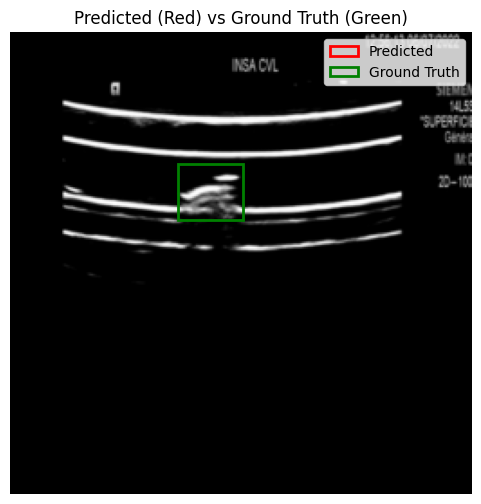

C8SteerableCNN(
  (block1): SequentialModule(
    (0): MaskModule()
    (1): R2Conv([C8_on_R2[(None, 8)]: {irrep_0 (x1)}(1)], [C8_on_R2[(None, 8)]: {regular (x24)}(192)], kernel_size=7, stride=1, padding=1, bias=False)
    (2): InnerBatchNorm([C8_on_R2[(None, 8)]: {regular (x24)}(192)], eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True, type=[C8_on_R2[(None, 8)]: {regular (x24)}(192)])
  )
  (block2): SequentialModule(
    (0): R2Conv([C8_on_R2[(None, 8)]: {regular (x24)}(192)], [C8_on_R2[(None, 8)]: {regular (x48)}(384)], kernel_size=5, stride=1, padding=2, bias=False)
    (1): InnerBatchNorm([C8_on_R2[(None, 8)]: {regular (x48)}(384)], eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True, type=[C8_on_R2[(None, 8)]: {regular (x48)}(384)])
  )
  (pool1): SequentialModule(
    (0): PointwiseAvgPoolAntialiased2D()
  )
  (block3): SequentialModule(
    (0): R2Conv([C8_on_R2[(None, 8)]: {regular (x48)}(384)], [C

In [123]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch

model = C8SteerableCNN().to(device)

print("Number of parameters:", sum(p.numel() for p in model.parameters()))

def denormalize_bbox(bbox, img_size):
    """Convert normalized bbox [cx, cy, w, h] to [x_min, y_min, w, h] in pixel space."""
    cx, cy, w, h = bbox
    cx *= img_size
    cy *= img_size
    w *= img_size
    h *= img_size
    x_min = cx - w / 2
    y_min = cy - h / 2
    return [x_min, y_min, w, h]

def test_model(model: torch.nn.Module, x: Image, y_true: torch.Tensor):
    model.eval()
    np.set_printoptions(linewidth=10000)
    
    # Resize and convert to tensor
    x_resized = resize2(x)
    x_tensor = totensor(x_resized).reshape(1, 1, resize, resize).to(device)

    print()
    print('##########################################################################################')
    with torch.no_grad():
        y_pred = model(x_tensor).to('cpu').numpy().squeeze()
        print('\nPredicted:', y_pred)
        print('Ground truth:', y_true.numpy())
    print('##########################################################################################')
    print()

    # Plotting
    fig, ax = plt.subplots(1, figsize=(6, 6))
    ax.imshow(x_resized, cmap='gray')

    # Draw predicted box (red)
    pred_box = denormalize_bbox(y_pred, resize)
    rect_pred = patches.Rectangle((pred_box[0], pred_box[1]), pred_box[2], pred_box[3],
                                  linewidth=2, edgecolor='r', facecolor='none', label='Predicted')
    ax.add_patch(rect_pred)

    # Draw ground truth box (green)
    true_box = denormalize_bbox(y_true.numpy(), resize)
    rect_true = patches.Rectangle((true_box[0], true_box[1]), true_box[2], true_box[3],
                                  linewidth=2, edgecolor='g', facecolor='none', label='Ground Truth')
    ax.add_patch(rect_true)

    ax.legend()
    ax.set_title("Predicted (Red) vs Ground Truth (Green)")
    plt.axis('off')
    plt.show()


# retrieve the first image from the test set
raw_US_test = USMicroMagDataset(mode=f'test', microrobot_type='flagella')
x, y = next(iter(raw_US_test))

# evaluate the model
test_model(model, x, y)
print(model)

In [43]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Sequential(         
            torch.nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=3, # prob drop this to 3 (which is normally done)
                stride=1,                   
                padding=1, # not much of a benefit + computationally efficient w/out, but if it was 0, the dimensions would reduce to 26x26
            ),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv2 = torch.nn.Sequential(         
            torch.nn.Conv2d(16, 32, 5, 1, 2),     
            torch.nn.ReLU(),                      
            torch.nn.MaxPool2d(kernel_size=2, stride=2),                
        )
        # fully connected layer, output 10 classes
        self.fc = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Linear(32 * 7 * 7, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 10) # reduce number of nodes
        )
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        output = self.fc(x)
        return output, x    # return x for visualization

In [3]:
# Device configuration
comp = 'cpu'
if torch.cuda.is_available():
    comp = 'cuda' # nvidia gpu parallelization
elif torch.backends.mps.is_available():
    comp = 'mps' # mac Metal Performance Shaders (high performance gpu)

# comp = 'cpu'
device = torch.device(comp)
device


device(type='mps')

## Part 3. Dataset Class: USMicroMagDataset

This class loads the preprocessed `.amat` file and makes the data available for your model. Each row in the file is expected to contain:

- **Flattened image pixels** (from a 1920×1080 grayscale image).
- **Label values** (for example, 5 numbers that include a class and bounding box coordinates).

The class converts the image back into its 2D shape and applies any provided transformations.

#### Visualize the resize

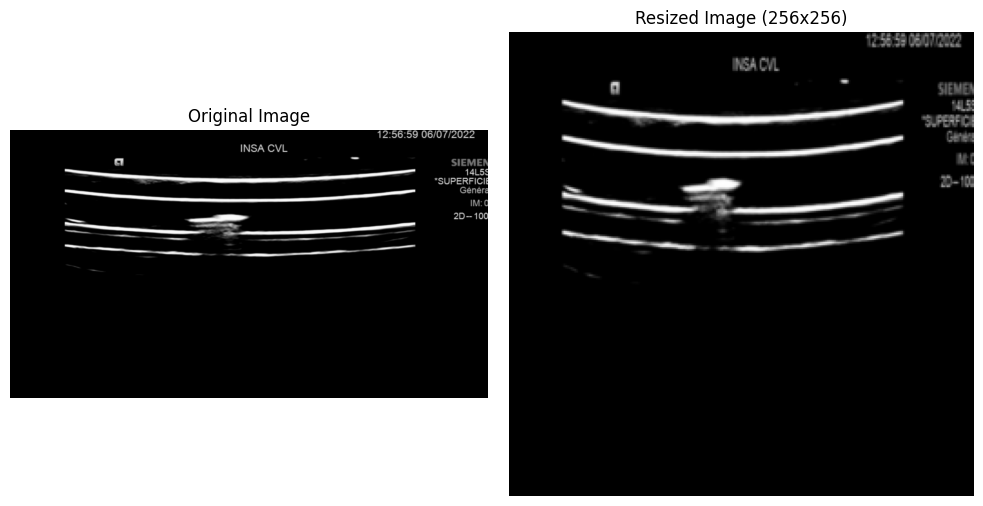

In [4]:
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import os
import random

# Example image path — change microrobot_type and mode if needed
microrobot_type = "flagella"  # or whatever type you're using
mode = "train"
img_dir = f"UsMicroMagSet-main/{microrobot_type}/images/{mode}"

# Pick the first image in the directory
img_path = os.path.join(img_dir, random.choice(os.listdir(img_dir)))

# Load original image
original_image = Image.open(img_path).convert('L')

resize = 256
# Resize transform
resize_transform = transforms.Resize((resize, resize))
resized_image = resize_transform(original_image)

# Plot both
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(f"Resized Image ({resize}x{resize})")
plt.imshow(resized_image, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

In [5]:
class USMicroMagDataset(Dataset):
    """
    Dataset class for ultrasound microrobot data using preprocessed .amat files.
    
    Each row in the .amat file is formatted as:
      [ flattened_pixels (1920*1080 values)  label_values (e.g., 5 numbers) ]
    """
    def __init__(self, mode='train', microrobot_type='flagella', transform=None):
        """
        Args:
            mode (str): 'train' or 'test'
            microrobot_type (str): e.g., "cylinder"
            transform (callable, optional): Transformations to apply to the image.
        """
        assert mode.startswith('train') or mode.startswith('test'), "Mode must start with 'train' or 'test'" # can be smt like train_50
        
        self.image_dir = f"UsMicroMagSet-main/{microrobot_type}/images/{mode}"
        self.label_dir = f"UsMicroMagSet-main/{microrobot_type}/labels/{mode}"
        self.transform = transform

        # List of all image file paths, sorted for consistency
        self.image_paths = sorted([
            os.path.join(self.image_dir, fname)
            for fname in os.listdir(self.image_dir)
            if fname.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))
        ])

        self.num_samples = len(self.image_paths)
    
    def __getitem__(self, index):
        img_path = self.image_paths[index]
        image = Image.open(img_path).convert('L')  # grayscale

        # Build label path and read last 4 values as float tensor (center_x, center_y, width, height)
        fname = os.path.splitext(os.path.basename(img_path))[0]
        label_path = os.path.join(self.label_dir, f"{fname}.txt")
        with open(label_path, 'r') as f:
            line = f.readline().strip().split()
            label_values = list(map(float, line[1:]))  # ignore first value
            label = torch.tensor(label_values, dtype=torch.float32) # mps only works with float32 not 64

        if self.transform:
            image = self.transform(image)

        return image, label
    
    def __len__(self):
        return self.num_samples

# resize1 = Resize(512)
resize2 = Resize((resize, resize))
totensor = ToTensor()

In [6]:
train_transform = Compose([
    # pad_to_square, # resize from 1920x1080 to 1920x1920
    # tried to upsample for rotation - resize to 2200
    # kernel isn't loading, instead downsizing
    # resize1,
    # RandomRotation(180., interpolation=InterpolationMode.BILINEAR, expand=False), # data augmentation to help with generalization
    resize2,
    totensor
])

test_transform = Compose([
    # pad_to_square,
    resize2,
    totensor
])

US_train = USMicroMagDataset(mode=f'train', microrobot_type='flagella', transform=train_transform)
train_loader = torch.utils.data.DataLoader(US_train, batch_size=64)
print("US_train len:", len(US_train))

US_test = USMicroMagDataset(mode=f'test', microrobot_type='flagella', transform=test_transform)
test_loader = torch.utils.data.DataLoader(US_test, batch_size=8)
print("US_train len:", len(US_test))

loader = {
    "train": train_loader,
    "test": test_loader
}

US_train len: 1505
US_train len: 1054


Let's build the model

In [20]:
model = C8SteerableCNN().to(device)

# Can choose to load pretrained model here
# model.load_state_dict(torch.load(f"c8_steerable_bbox_model_SmoothL1Loss_{max_images}.pth"))
# model.to(device)
# model.eval()

c 1536


In [8]:
print(sum(p.numel() for p in model.parameters()))

# from torchsummary import summary

# print(summary(model, input_size=(1, 256,256))) # LOOK INTO THIS
print(model)

1077684
C8SteerableCNN(
  (block1): SequentialModule(
    (0): MaskModule()
    (1): R2Conv([C8_on_R2[(None, 8)]: {irrep_0 (x1)}(1)], [C8_on_R2[(None, 8)]: {regular (x24)}(192)], kernel_size=7, stride=1, padding=1, bias=False)
    (2): InnerBatchNorm([C8_on_R2[(None, 8)]: {regular (x24)}(192)], eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True, type=[C8_on_R2[(None, 8)]: {regular (x24)}(192)])
  )
  (block2): SequentialModule(
    (0): R2Conv([C8_on_R2[(None, 8)]: {regular (x24)}(192)], [C8_on_R2[(None, 8)]: {regular (x24)}(192)], kernel_size=5, stride=1, padding=2, bias=False)
    (1): InnerBatchNorm([C8_on_R2[(None, 8)]: {regular (x24)}(192)], eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True, type=[C8_on_R2[(None, 8)]: {regular (x24)}(192)])
  )
  (pool1): SequentialModule(
    (0): PointwiseAvgPoolAntialiased2D()
  )
  (block3): SequentialModule(
    (0): R2Conv([C8_on_R2[(None, 8)]: {regular (x24)}(1

The model is now randomly initialized. 
Therefore, we do not expect it to produce the right class probabilities.

However, the model should still produce the same output for rotated versions of the same image.
This is true for rotations by multiples of $\frac{\pi}{2}$, but is only approximate for rotations by $\frac{\pi}{4}$.

Let's test it on a random test image:
we feed eight rotated versions of the first image in the test set and print the output logits of the model for each of them.

Number of parameters: 1077684

##########################################################################################

Predicted: [ 18.471115  26.701702 -35.0135    65.24697 ]
Ground truth: [0.432031 0.344907 0.139063 0.121296]
##########################################################################################



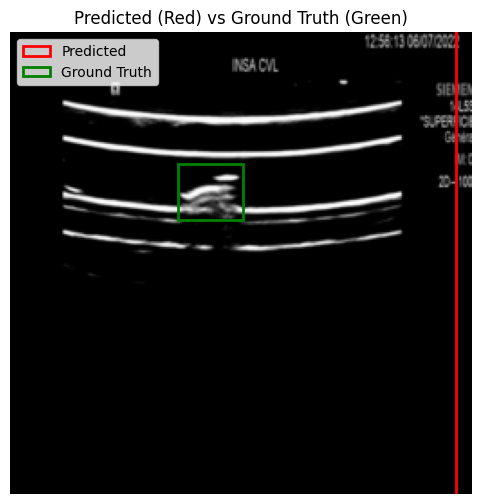

C8SteerableCNN(
  (block1): SequentialModule(
    (0): MaskModule()
    (1): R2Conv([C8_on_R2[(None, 8)]: {irrep_0 (x1)}(1)], [C8_on_R2[(None, 8)]: {regular (x24)}(192)], kernel_size=7, stride=1, padding=1, bias=False)
    (2): InnerBatchNorm([C8_on_R2[(None, 8)]: {regular (x24)}(192)], eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True, type=[C8_on_R2[(None, 8)]: {regular (x24)}(192)])
  )
  (block2): SequentialModule(
    (0): R2Conv([C8_on_R2[(None, 8)]: {regular (x24)}(192)], [C8_on_R2[(None, 8)]: {regular (x24)}(192)], kernel_size=5, stride=1, padding=2, bias=False)
    (1): InnerBatchNorm([C8_on_R2[(None, 8)]: {regular (x24)}(192)], eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True, type=[C8_on_R2[(None, 8)]: {regular (x24)}(192)])
  )
  (pool1): SequentialModule(
    (0): PointwiseAvgPoolAntialiased2D()
  )
  (block3): SequentialModule(
    (0): R2Conv([C8_on_R2[(None, 8)]: {regular (x24)}(192)], [C

In [32]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch

# model = C8SteerableCNN().to(device)

print("Number of parameters:", sum(p.numel() for p in model.parameters()))

def denormalize_bbox(bbox, img_size):
    """Convert normalized bbox [cx, cy, w, h] to [x_min, y_min, w, h] in pixel space."""
    cx, cy, w, h = bbox
    cx *= img_size
    cy *= img_size
    w *= img_size
    h *= img_size
    x_min = cx - w / 2
    y_min = cy - h / 2
    return [x_min, y_min, w, h]

def test_model(model: torch.nn.Module, x: Image, y_true: torch.Tensor):
    model.eval()
    np.set_printoptions(linewidth=10000)
    
    # Resize and convert to tensor
    x_resized = resize2(x)
    x_tensor = totensor(x_resized).reshape(1, 1, resize, resize).to(device)

    print()
    print('##########################################################################################')
    with torch.no_grad():
        y_pred = model(x_tensor).to('cpu').numpy().squeeze()
        print('\nPredicted:', y_pred)
        print('Ground truth:', y_true.numpy())
    print('##########################################################################################')
    print()

    # Plotting
    fig, ax = plt.subplots(1, figsize=(6, 6))
    ax.imshow(x_resized, cmap='gray')

    # Draw predicted box (red)
    pred_box = denormalize_bbox(y_pred, resize)
    rect_pred = patches.Rectangle((pred_box[0], pred_box[1]), pred_box[2], pred_box[3],
                                  linewidth=2, edgecolor='r', facecolor='none', label='Predicted')
    ax.add_patch(rect_pred)

    # Draw ground truth box (green)
    true_box = denormalize_bbox(y_true.numpy(), resize)
    rect_true = patches.Rectangle((true_box[0], true_box[1]), true_box[2], true_box[3],
                                  linewidth=2, edgecolor='g', facecolor='none', label='Ground Truth')
    ax.add_patch(rect_true)

    ax.legend()
    ax.set_title("Predicted (Red) vs Ground Truth (Green)")
    plt.axis('off')
    plt.show()


# retrieve the first image from the test set
raw_US_test = USMicroMagDataset(mode=f'test', microrobot_type='flagella')
x, y = next(iter(raw_US_test))

# evaluate the model
test_model(model, x, y)
print(model)

So, let's train the model now.
The model is exactly the same used to train a normal *PyTorch* architecture:

Note:
- **MSE Loss (torch.nn.MSELoss)** penalizes the squared error between predictions and targets. It's sensitive to large errors (outliers) since errors are squared.

- **Smooth L1 Loss (torch.nn.SmoothL1Loss)** is less sensitive to outliers because it behaves like an L1 loss for large errors and like an L2 loss for small errors. It’s often preferred in bounding box regression tasks.



In [127]:
# loss_function = torch.nn.CrossEntropyLoss() # This is for classification tasks
# loss_function = torch.nn.MSELoss() # can use SmoothL1Loss() or MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-5)

In [28]:
def cxcywh_to_xyxy(boxes):
    cx, cy, w, h = boxes.unbind(-1)
    x1 = cx - w / 2
    y1 = cy - h / 2
    x2 = cx + w / 2
    y2 = cy + h / 2
    return torch.stack([x1, y1, x2, y2], dim=-1)

def iou_loss(preds, targets):
    # Convert to corners
    pred_boxes = cxcywh_to_xyxy(preds)
    target_boxes = cxcywh_to_xyxy(targets)

    # Intersection
    x1 = torch.max(pred_boxes[..., 0], target_boxes[..., 0])
    y1 = torch.max(pred_boxes[..., 1], target_boxes[..., 1])
    x2 = torch.min(pred_boxes[..., 2], target_boxes[..., 2])
    y2 = torch.min(pred_boxes[..., 3], target_boxes[..., 3])

    inter_w = (x2 - x1).clamp(min=0)
    inter_h = (y2 - y1).clamp(min=0)
    inter_area = inter_w * inter_h

    # Areas
    pred_area = (pred_boxes[..., 2] - pred_boxes[..., 0]) * (pred_boxes[..., 3] - pred_boxes[..., 1])
    target_area = (target_boxes[..., 2] - target_boxes[..., 0]) * (target_boxes[..., 3] - target_boxes[..., 1])

    union_area = pred_area + target_area - inter_area
    iou = inter_area / union_area.clamp(min=1e-6)

    return 1 - iou.mean()

def giou_loss(preds, targets):
    # Convert to [x1, y1, x2, y2]
    pred_boxes = cxcywh_to_xyxy(preds)
    target_boxes = cxcywh_to_xyxy(targets)

    # Intersection
    x1 = torch.max(pred_boxes[..., 0], target_boxes[..., 0])
    y1 = torch.max(pred_boxes[..., 1], target_boxes[..., 1])
    x2 = torch.min(pred_boxes[..., 2], target_boxes[..., 2])
    y2 = torch.min(pred_boxes[..., 3], target_boxes[..., 3])

    inter_w = (x2 - x1).clamp(min=0)
    inter_h = (y2 - y1).clamp(min=0)
    inter_area = inter_w * inter_h

    # Areas
    pred_area = (pred_boxes[..., 2] - pred_boxes[..., 0]) * (pred_boxes[..., 3] - pred_boxes[..., 1])
    target_area = (target_boxes[..., 2] - target_boxes[..., 0]) * (target_boxes[..., 3] - target_boxes[..., 1])

    union_area = pred_area + target_area - inter_area
    iou = inter_area / union_area.clamp(min=1e-6)

    # Smallest enclosing box
    x1_c = torch.min(pred_boxes[..., 0], target_boxes[..., 0])
    y1_c = torch.min(pred_boxes[..., 1], target_boxes[..., 1])
    x2_c = torch.max(pred_boxes[..., 2], target_boxes[..., 2])
    y2_c = torch.max(pred_boxes[..., 3], target_boxes[..., 3])
    
    enclose_w = (x2_c - x1_c).clamp(min=0)
    enclose_h = (y2_c - y1_c).clamp(min=0)
    enclose_area = enclose_w * enclose_h

    giou = iou - (enclose_area - union_area) / enclose_area.clamp(min=1e-6)
    return 1 - giou.mean()

optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-5)

# Load checkpoint
checkpoint = torch.load("checkpoints/interrupted_model_20250408_11:27.pth", map_location=device)
# checkpoint = torch.load("checkpoints/model_checkpoint_20250408_11:24.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'], strict=False)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch'] + 1  # continue from next epoch

##### Training the model

Run `tensorboard --logdir=runs` in the terminal to see tensorboard logging

In [14]:
epochs = 4
eval_interval = 2

from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir="runs/c8_bbox_run")  # customize the name if needed

try:
    for epoch in range(epochs):
        print("Epoch:", epoch)
        model.train()
        print("Length of train loader", len(train_loader))
        
        epoch_train_loss = 0.0
        total_train_samples = 0

        for i, (imgs, labels) in enumerate(train_loader):
            print(f"Batch {i} | imgs.shape: {imgs.shape} | labels.shape: {labels.shape}")
            
            optimizer.zero_grad()
            imgs = imgs.to(device)
            labels = labels.to(device).float()

            y = model(imgs)
            loss = giou_loss(y, labels)
            loss.backward()
            optimizer.step()

            # Accumulate training loss
            epoch_train_loss += loss.item() * imgs.size(0)
            total_train_samples += imgs.size(0)

        print("\n💾 Checkpoint saved at interrupted epoch:", epoch)
        timestamp = datetime.now().strftime("%Y%m%d_%H:%M")
        location = f"checkpoints/model_checkpoint_{timestamp}.pth"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
        }, location)
        print(f"✅ Model saved to", location)
        
        # Log average training loss for this epoch
        avg_train_loss = epoch_train_loss / total_train_samples
        writer.add_scalar("Loss/Train", avg_train_loss, epoch)

        # Evaluation step every x epochs
        if epoch % eval_interval == 0:
            total_loss = 0.0
            total_samples = 0
            model.eval()
            with torch.no_grad():
                for i, (imgs, labels) in enumerate(test_loader):
                    imgs = imgs.to(device)
                    labels = labels.to(device).float()
                    
                    y = model(imgs)
                    loss = giou_loss(y, labels)
                    total_loss += loss.item() * imgs.size(0)
                    total_samples += imgs.size(0)
            
            avg_loss = total_loss / total_samples
            print(f"Epoch {epoch} | Test loss: {avg_loss:.4f}")
            writer.add_scalar("Loss/Test", avg_loss, epoch)

except KeyboardInterrupt:
    print("\n🛑 Training interrupted by user. Saving checkpoint...")
    timestamp = datetime.now().strftime("%Y%m%d_%H:%M")
    location = f"checkpoints/interrupted_model_{timestamp}.pth"
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, location)
    print(f"✅ Model saved to", location)


Epoch: 0
Length of train loader 24
Batch 0 | imgs.shape: torch.Size([64, 1, 256, 256]) | labels.shape: torch.Size([64, 4])
Batch 1 | imgs.shape: torch.Size([64, 1, 256, 256]) | labels.shape: torch.Size([64, 4])
Batch 2 | imgs.shape: torch.Size([64, 1, 256, 256]) | labels.shape: torch.Size([64, 4])
Batch 3 | imgs.shape: torch.Size([64, 1, 256, 256]) | labels.shape: torch.Size([64, 4])
Batch 4 | imgs.shape: torch.Size([64, 1, 256, 256]) | labels.shape: torch.Size([64, 4])
Batch 5 | imgs.shape: torch.Size([64, 1, 256, 256]) | labels.shape: torch.Size([64, 4])
Batch 6 | imgs.shape: torch.Size([64, 1, 256, 256]) | labels.shape: torch.Size([64, 4])
Batch 7 | imgs.shape: torch.Size([64, 1, 256, 256]) | labels.shape: torch.Size([64, 4])
Batch 8 | imgs.shape: torch.Size([64, 1, 256, 256]) | labels.shape: torch.Size([64, 4])
Batch 9 | imgs.shape: torch.Size([64, 1, 256, 256]) | labels.shape: torch.Size([64, 4])
Batch 10 | imgs.shape: torch.Size([64, 1, 256, 256]) | labels.shape: torch.Size([64, 

### Save the model

In [49]:
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H:%M")
torch.save(model.state_dict(), f"pretrained_models/c8_steerable_bbox_model_GIoU_{timestamp}.pth")

## Part 4. Test and Visualize Model on Random Images

In [16]:
import matplotlib.pyplot as plt
import random

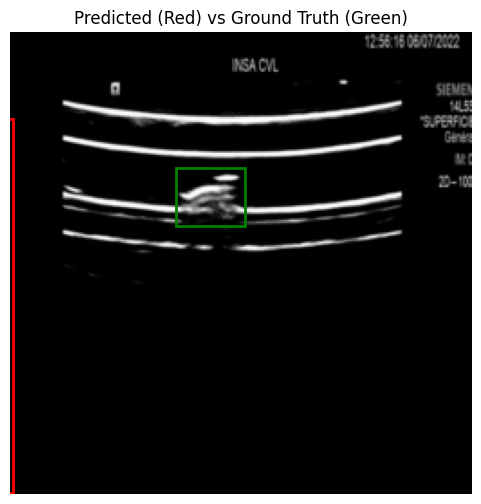

In [17]:
# Take one random image from the test set
model.eval()

# Get a single batch
imgs, labels = next(iter(test_loader))
index = random.randint(0, imgs.size(0) - 1)

img = imgs[index].unsqueeze(0).to(device)  # shape: [1, 1, 256, 256]
true_bbox = labels[index].cpu().numpy()    # shape: [4]

# Predict bounding box
with torch.no_grad():
    pred_bbox = model(img).squeeze().cpu().numpy()

# Rescale bbox to image size (256x256)
def rescale_bbox(bbox, size=256):
    cx, cy, w, h = bbox
    x1 = (cx - w / 2) * size
    y1 = (cy - h / 2) * size
    x2 = (cx + w / 2) * size
    y2 = (cy + h / 2) * size
    return [x1, y1, x2, y2]

pred_box_px = rescale_bbox(pred_bbox)
true_box_px = rescale_bbox(true_bbox)

# Plot the image with predicted and true bounding box
img_np = imgs[index].squeeze().numpy()

plt.figure(figsize=(6, 6))
plt.imshow(img_np, cmap='gray')
plt.title("Predicted (Red) vs Ground Truth (Green)")

# Draw predicted bbox
plt.gca().add_patch(plt.Rectangle(
    (pred_box_px[0], pred_box_px[1]),
    pred_box_px[2] - pred_box_px[0],
    pred_box_px[3] - pred_box_px[1],
    linewidth=2, edgecolor='r', facecolor='none'
))

# Draw ground truth bbox
plt.gca().add_patch(plt.Rectangle(
    (true_box_px[0], true_box_px[1]),
    true_box_px[2] - true_box_px[0],
    true_box_px[3] - true_box_px[1],
    linewidth=2, edgecolor='g', facecolor='none'
))

plt.axis('off')
plt.show()

## Copy paste cells

### Running SmoothL1Loss

Epoch: 0
Length of train loader 7
Batch 0 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 1 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 2 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 3 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 4 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 5 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 6 | imgs.shape: torch.Size([2, 1, 256, 256]) | labels.shape: torch.Size([2, 4])
Epoch 0 | Test loss: 1.2231
Epoch: 1
Length of train loader 7
Batch 0 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 1 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 2 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 3 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 4 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 5 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 6 | imgs.shape: torch.Size([2, 1, 256, 256]) | labels.shape: torch.Size([2, 4])
Epoch: 2
Length of train loader 7
Batch 0 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 1 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 2 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 3 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 4 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 5 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 6 | imgs.shape: torch.Size([2, 1, 256, 256]) | labels.shape: torch.Size([2, 4])
Epoch: 3
Length of train loader 7
Batch 0 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 1 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 2 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 3 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 4 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 5 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 6 | imgs.shape: torch.Size([2, 1, 256, 256]) | labels.shape: torch.Size([2, 4])
Epoch: 4
Length of train loader 7
Batch 0 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 1 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 2 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 3 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 4 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 5 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 6 | imgs.shape: torch.Size([2, 1, 256, 256]) | labels.shape: torch.Size([2, 4])
Epoch: 5
Length of train loader 7
Batch 0 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 1 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 2 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 3 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 4 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 5 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 6 | imgs.shape: torch.Size([2, 1, 256, 256]) | labels.shape: torch.Size([2, 4])
Epoch: 6
Length of train loader 7
Batch 0 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 1 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 2 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 3 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 4 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 5 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 6 | imgs.shape: torch.Size([2, 1, 256, 256]) | labels.shape: torch.Size([2, 4])
Epoch: 7
Length of train loader 7
Batch 0 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 1 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 2 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 3 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 4 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 5 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 6 | imgs.shape: torch.Size([2, 1, 256, 256]) | labels.shape: torch.Size([2, 4])
Epoch: 8
Length of train loader 7
Batch 0 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 1 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 2 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 3 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 4 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 5 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 6 | imgs.shape: torch.Size([2, 1, 256, 256]) | labels.shape: torch.Size([2, 4])
Epoch: 9
Length of train loader 7
Batch 0 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 1 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 2 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 3 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 4 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 5 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 6 | imgs.shape: torch.Size([2, 1, 256, 256]) | labels.shape: torch.Size([2, 4])
Epoch: 10
Length of train loader 7
Batch 0 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 1 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 2 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 3 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 4 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 5 | imgs.shape: torch.Size([8, 1, 256, 256]) | labels.shape: torch.Size([8, 4])
Batch 6 | imgs.shape: torch.Size([2, 1, 256, 256]) | labels.shape: torch.Size([2, 4])
Epoch 10 | Test loss: 0.0504

<img src="desc_images/SmoothL1Loss.png" alt="SmoothL1Loss Summary" width="600">